Start searching through multiple videos at once for segments that match a certain input video.

In [2]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np

In [3]:
import json

In [4]:
!pip install --upgrade moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! git clone https://github.com/kenshohara/video-classification-3d-cnn-pytorch.git

Cloning into 'video-classification-3d-cnn-pytorch'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 158.63 KiB | 2.11 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
%cd video-classification-3d-cnn-pytorch/

/content/video-classification-3d-cnn-pytorch


In [ ]:
def loadVideosToInfile(folder):
    videos = os.listdir(folder)
    with open('input', 'w') as inputfile:
      for v in videos:
        if v.split('.')[-1] == 'mp4':
          inputfile.write(v+'\n')

In [ ]:
loadVideosToInfile('/content/drive/MyDrive/allvideostuff/video/videofeature')

In [ ]:
! python main.py --input input --video_root /content/drive/MyDrive/allvideostuff/video/videofeature --output /content/drive/MyDrive/allvideostuff/video/videoout/outputCcandBbFeatures.json  --model /content/drive/MyDrive/allvideostuff/video/resnet-34-kinetics-cpu.pth  --no_cuda --mode feature

loading model /content/drive/MyDrive/allvideostuff/video/resnet-34-kinetics-cpu.pth
/content/drive/MyDrive/allvideostuff/video/videofeature/chinesecalligraphy.mp4
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enab

In [ ]:
def readAllOutput(outputFolder):
  dictionaries = {}
  filesname = os.listdir(outputFolder)
  for f in filesname:
    if f.split('.')[-1] == 'json':
      file = open(outputFolder+'/'+f)
      segments = json.load(file)
      for s in segments:
        dictionaries[s['video']] = s
  return dictionaries

In [ ]:
dicts = readAllOutput('/content/drive/MyDrive/allvideostuff/video/videoout')

In [ ]:
dicts.keys()

dict_keys(['chinesecalligraphy.mp4', 'billboard.mp4'])

In [ ]:
dicts['chinesecalligraphy.mp4']['clips'][0].keys()

dict_keys(['segment', 'features'])

In [ ]:
# here keyFilmName is the name of the film that you want to find a match for, and the feature dictionary is 
# the dictionary that is given as output by the readAllOutput function

def searchForMatch(keyFilmName, featureDictionary):
    # create variables to keep track of the best clips
    bestRangeStart = 0
    bestRangeFilmName = ''
    bestRangeScore = 1000000000
    
    # first read the features of the keyFilm into keyFeatures
    keyClips = featureDictionary[keyFilmName]['clips']
    keyFeatures = []
    for c in keyClips:
      keyFeatures.append(np.array(c['features']))
    
    # now enter a for loop to go through all films, and see what the best matching sequence is 
    # (we make sure not to check the keyFilm itself by checking it's not that filename)
    for film in featureDictionary.keys():
        if not film == keyFilmName:
          filmClips = featureDictionary[film]['clips']
          filmFeatures = []
          for c in filmClips:
            filmFeatures.append(np.array(c['features']))
          for i in range(len(filmFeatures)-len(keyFeatures)):
            distance = 0
            for j in range(len(keyFeatures)):
              d = np.linalg.norm(filmFeatures[i+j]-keyFeatures[j])
              distance += d
              if distance < bestRangeScore:
                bestRangeScore = distance
                bestRangeStart = i
                bestRangeFilmName = film
                
            
            # so now here 'film' is a filename (which is the key in the feature dictionary of that film)
            # first load the features in a 'filmFeatures' list like we did for key Features
            # then look at the provided code from the lecture to see how to iterate through the other
            # list of features to find the best segment. Now just make sure to also register what film
            # name the best matching segment is from. 
            
    # create a list containing the filename, start and nr of clips
    matchingFragment = [bestRangeFilmName, bestRangeStart, len(keyFeatures)]
    
    return matchingFragment

    # First implement it for the best matching one, then expand it to return the n best matching ones as a list,
    # with n as an argument in the function

In [ ]:
matchingFragment = searchForMatch("chinesecalligraphy.mp4", dicts)

In [ ]:
# this is a helper function to which you give the fragment (the output of the searchForMatch function), and it returns
# a moviepy film object (which you can then save)

def extractFragment(fragment, filmFolder):
    # here adapt the code from the lecture, but make it so that it works for any input fragment list
    # the output of the function above: [bestRangeFilmName, bestRangeStart, len(keyFeatures)]
    
    filmFileName = fragment[0]
    start = fragment[1]
    nrClips = fragment[2]
    
    filmPath = os.path.join(filmFolder, filmFileName)
    print(filmPath)
    filmVideo = VideoFileClip(filmPath)
    filmfps = filmVideo.fps
    filmFrameLength = 1/filmfps
    
    nrFrames = nrClips * 16
    startFrame = start * 16
    
    startTime = startFrame * filmFrameLength
    endTime = startTime + nrFrames * filmFrameLength
    
    filmMatchedVideo = filmVideo.subclip(startTime, endTime)
    
    
    return filmMatchedVideo

    # This function should read all .json files in the output folder, and combine them into one large dictionary

In [ ]:
# a small piece of code that moves all processed input films to the processed films folder

input_films_processed = os.listdir('/content/drive/MyDrive/allvideostuff/video/videotoprocess')
for file in input_films_processed:
    try:
        shutil.move(os.path.join('/content/drive/MyDrive/allvideostuff/video/videofeature',file),'/content/drive/MyDrive/allvideostuff/video/videofeature')
    except:
        print(file + ' not moved')


calligraphy.mp4 not moved
publicspace.mp4 not moved
chinesecalligraphy.mp4 not moved
billboard.mp4 not moved


In [ ]:
# read all output with the function declared above

dicts= readAllOutput('/content/drive/MyDrive/allvideostuff/video/videoout')

In [ ]:
dicts.keys()

dict_keys(['chinesecalligraphy.mp4', 'billboard.mp4'])

In [ ]:
fragment = searchForMatch('billboard.mp4', dicts)

In [ ]:
fragment

['chinesecalligraphy.mp4', 0, 31]

In [ ]:
from moviepy.editor import VideoFileClip

from moviepy.video.io.VideoFileClip import VideoFileClip

In [ ]:
# extract the fragment from the film
filmFolder = '/content/drive/MyDrive/allvideostuff/video/videofeature'
CcMatchBbVideo = extractFragment(fragment, filmFolder)

NameError: ignored

In [ ]:
# display the film fragment

CcMatchBbVideo.ipython_display()

In [ ]:
CcMatchBbVideo.write_videofile("/content/drive/MyDrive/allvideostuff/video/videoout/CcMatchBbVideo.mp4",audio_codec='aac')

Moviepy - Building video /content/drive/MyDrive/allvideostuff/video/videoout/CcMatchBbVideo.mp4.
MoviePy - Writing audio in CcMatchBbVideoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/allvideostuff/video/videoout/CcMatchBbVideo.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/allvideostuff/video/videoout/CcMatchBbVideo.mp4


In [ ]:
CcMatchBbVideo.duration

29.176470588235293

In [ ]:
frame=CcMatchBbVideo.get_frame(12)

In [ ]:
from PIL import Image

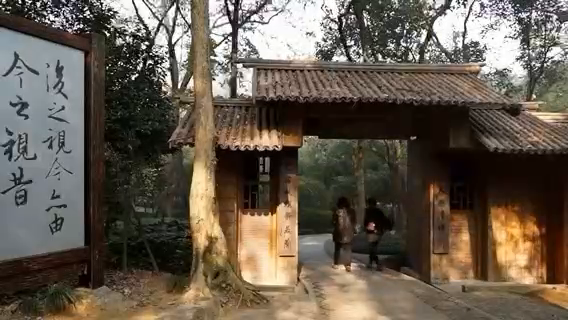

In [ ]:
Image.fromarray(frame,'RGB')

Use moviepy to export frames of videos, and run the image model on the frames (with the feature vector as output, so after removing the top). Use the feature vector outputs of the frames and of input images to look for fragments of video that match the input images.

In [ ]:
file = open('/content/drive/MyDrive/allvideostuff/video/videoout/outputCcandBbFeatures.json')
segments = json.load(file)

In [ ]:
ImageFeatures = []
for s in segments[0]['clips']:
  ImageFeatures.append(np.array(s['features']))

In [ ]:
ImageFeatures[0]

array([1.15403342e+00, 8.36152673e-01, 6.76270485e-01, 4.81391400e-02,
       2.65878886e-02, 8.26452076e-01, 2.30432972e-01, 1.73124290e+00,
       7.15545535e-01, 5.51754348e-02, 1.39179873e+00, 2.60615230e-01,
       1.73670113e+00, 1.94762066e-01, 5.56096360e-02, 1.55715358e+00,
       2.65140438e+00, 2.75094330e-01, 8.07752013e-02, 8.96551073e-01,
       1.09166658e+00, 1.42023408e+00, 2.93549389e-01, 1.26699424e+00,
       3.04009628e+00, 1.99578017e-01, 2.37740979e-01, 5.98439813e-01,
       8.67057920e-01, 5.84790885e-01, 2.12552384e-01, 1.66562587e-01,
       8.11259568e-01, 0.00000000e+00, 3.45577225e-02, 2.37442732e-01,
       8.71521533e-01, 3.13255191e-01, 1.22423410e+00, 3.45096421e+00,
       0.00000000e+00, 7.95360267e-01, 1.79428849e-02, 1.21525489e-03,
       9.92426351e-02, 2.98652738e-01, 2.68188059e-01, 2.68252529e-02,
       1.67025054e+00, 1.89920676e+00, 3.12997371e-01, 9.79201123e-02,
       4.95396912e-01, 0.00000000e+00, 1.76445079e+00, 2.89574981e-01,
      

In [ ]:
VideoFeatures = []
for s in segments[1]['clips']:
  VideoFeatures.append(np.array(s['features']))

In [ ]:
bestRangeStart = 0
bestRangeScore = 1000000000
for i in range(len(VideoFeatures)-len(ImageFeatures)):
  distance = 0
  for j in range(len(VideoFeatures)):
    d = np.linalg.norm(VideoFeatures[i+j]-ImageFeatures[j])
    distance += d
    print(diatance)
    if distance < bestRangeScore:
      bestRangeScore = distance
      bestRangeStart = i

In [ ]:
def matchbest(targetFeatures, findingFeatures):
  bestRangeStart = 0
  bestRangeScore = 1000000000000
  for i in range(len(findingFeatures)-len(targetFeatures)):
    distance = 0
    for j in range(len(targetFeatures)):
      d = np.linalg.norm(findingFeatures[i+j]-targetFeatures[j])
      distance += d

      if distance < bestRangeScore:
        bestRangeScore = distance
        bestRangeStart = i
  return bestRangeStart

In [ ]:
bestRangeStart= matchbest (VideoFeatures,ImageFeatures)
print(bestRangeStart)

0


In [ ]:
ImageFeatures[0]

array([1.15403342e+00, 8.36152673e-01, 6.76270485e-01, 4.81391400e-02,
       2.65878886e-02, 8.26452076e-01, 2.30432972e-01, 1.73124290e+00,
       7.15545535e-01, 5.51754348e-02, 1.39179873e+00, 2.60615230e-01,
       1.73670113e+00, 1.94762066e-01, 5.56096360e-02, 1.55715358e+00,
       2.65140438e+00, 2.75094330e-01, 8.07752013e-02, 8.96551073e-01,
       1.09166658e+00, 1.42023408e+00, 2.93549389e-01, 1.26699424e+00,
       3.04009628e+00, 1.99578017e-01, 2.37740979e-01, 5.98439813e-01,
       8.67057920e-01, 5.84790885e-01, 2.12552384e-01, 1.66562587e-01,
       8.11259568e-01, 0.00000000e+00, 3.45577225e-02, 2.37442732e-01,
       8.71521533e-01, 3.13255191e-01, 1.22423410e+00, 3.45096421e+00,
       0.00000000e+00, 7.95360267e-01, 1.79428849e-02, 1.21525489e-03,
       9.92426351e-02, 2.98652738e-01, 2.68188059e-01, 2.68252529e-02,
       1.67025054e+00, 1.89920676e+00, 3.12997371e-01, 9.79201123e-02,
       4.95396912e-01, 0.00000000e+00, 1.76445079e+00, 2.89574981e-01,
      

In [ ]:
ImageFeatures[bestRangeStart]

array([1.15403342e+00, 8.36152673e-01, 6.76270485e-01, 4.81391400e-02,
       2.65878886e-02, 8.26452076e-01, 2.30432972e-01, 1.73124290e+00,
       7.15545535e-01, 5.51754348e-02, 1.39179873e+00, 2.60615230e-01,
       1.73670113e+00, 1.94762066e-01, 5.56096360e-02, 1.55715358e+00,
       2.65140438e+00, 2.75094330e-01, 8.07752013e-02, 8.96551073e-01,
       1.09166658e+00, 1.42023408e+00, 2.93549389e-01, 1.26699424e+00,
       3.04009628e+00, 1.99578017e-01, 2.37740979e-01, 5.98439813e-01,
       8.67057920e-01, 5.84790885e-01, 2.12552384e-01, 1.66562587e-01,
       8.11259568e-01, 0.00000000e+00, 3.45577225e-02, 2.37442732e-01,
       8.71521533e-01, 3.13255191e-01, 1.22423410e+00, 3.45096421e+00,
       0.00000000e+00, 7.95360267e-01, 1.79428849e-02, 1.21525489e-03,
       9.92426351e-02, 2.98652738e-01, 2.68188059e-01, 2.68252529e-02,
       1.67025054e+00, 1.89920676e+00, 3.12997371e-01, 9.79201123e-02,
       4.95396912e-01, 0.00000000e+00, 1.76445079e+00, 2.89574981e-01,
      

In [ ]:
def matchVideo(vpath, features, bestRangeStart):
  Rvideo = VideoFileClip(vpath)
  Rfps = Rvideo.fps
  RFrameLength = 1/Rfps

  nrFrames = len(features)*16
  startFrame = bestRangeStart*16

  startTime = startFrame*RFrameLength
  endTime = startTime+nrFrames*RFrameLength

  RMatchedVideo = Rvideo.subclip(startTime,endTime)
  return RMatchedVideo

In [ ]:
matchVideo('/content/drive/MyDrive/allvideostuff/video/videotoprocess/calligraphy.mp4', VideoFeatures, 0)

In [ ]:
matchVideo('/content/drive/MyDrive/allvideostuff/video/videotoprocess/calligraphy.mp4', VideoFeatures, 0).ipython_display()

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
